In [1]:
#Importing packages
import pandas as pd
import numpy as np

import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm, metrics
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

##import otter
##grader = otter.Notebook("final_project.ipynb")

In [2]:
adhd_dir = "ADHD"
non_adhd_dir = "NON-ADHD"

def combine_csv(folder_path, label):
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(os.path.join(folder_path, file)) for file in all_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df["Label"] = label
    return combined_df

adhd_data = combine_csv(adhd_dir, "ADHD")
non_adhd_data = combine_csv(non_adhd_dir, "Non-ADHD")

final_data = pd.concat([adhd_data, non_adhd_data], ignore_index=True)

final_data.to_csv("combined_eeg_data.csv", index=False)

print(final_data.head())
print(final_data["Label"].value_counts())

        Theta      Alpha   Low_beta  High_beta      Gamma Label
0         NaN        NaN        NaN        NaN        NaN  ADHD
1   85.030979  32.751042  23.572122  14.734582  10.666455  ADHD
2  107.404344  37.351060  19.584461   9.520036   3.704019  ADHD
3   80.391793  29.850818  15.416850   8.633861   3.079423  ADHD
4   85.746002  31.440121  17.153248  16.306663  12.068930  ADHD
Label
ADHD        10372
Non-ADHD     8337
Name: count, dtype: int64


In [3]:
#fixing dataset
final_data = final_data.dropna()

X_eeg = final_data.drop(["Label"], axis=1)
y_eeg = final_data["Label"]

print(final_data.dtypes)
print(final_data.head())

Theta        float64
Alpha        float64
Low_beta     float64
High_beta    float64
Gamma        float64
Label         object
dtype: object
        Theta      Alpha   Low_beta  High_beta      Gamma Label
1   85.030979  32.751042  23.572122  14.734582  10.666455  ADHD
2  107.404344  37.351060  19.584461   9.520036   3.704019  ADHD
3   80.391793  29.850818  15.416850   8.633861   3.079423  ADHD
4   85.746002  31.440121  17.153248  16.306663  12.068930  ADHD
5   82.449039  29.264649  19.009672   9.851333   5.347818  ADHD


In [4]:
## Splitting dataset
X_eeg_train_80, X_eeg_test_20, y_eeg_train_80, y_eeg_test_20 = train_test_split(X_eeg, y_eeg, test_size=0.20, random_state=42)
X_eeg_train_20, X_eeg_test_80, y_eeg_train_20, y_eeg_test_80 = train_test_split(X_eeg, y_eeg, test_size=0.80, random_state=42)
X_eeg_train_50, X_eeg_test_50, y_eeg_train_50, y_eeg_test_50 = train_test_split(X_eeg, y_eeg, test_size=0.50, random_state=42)

X_eeg_train_val_80, X_eeg_val_20, y_eeg_train_val_80, y_eeg_val_20 = train_test_split(X_eeg_train_80, y_eeg_train_80, test_size=0.20, random_state=42)
X_eeg_train_val_50, X_eeg_val_50, y_eeg_train_val_50, y_eeg_val_50 = train_test_split(X_eeg_train_50, y_eeg_train_50, test_size=0.50, random_state=42)
X_eeg_train_val_20, X_eeg_val_80, y_eeg_train_val_20, y_eeg_val_80 = train_test_split(X_eeg_train_20, y_eeg_train_20, test_size=0.80, random_state=42)


In [5]:
##SVM
def train_and_evaluate_svm(X_train, y_train, X_val, y_val, X_test, y_test):

    kernels = ['linear', 'rbf', 'poly']
    results = []
    training_errors = []
    validation_errors = []
    
    for c in range(3):

        sc_X = StandardScaler()
        X_train = sc_X.fit_transform(X_train)
        X_test = sc_X.transform(X_test)
        X_val = sc_X.transform(X_val)
        
        svm_classifier = svm.SVC(kernel=kernels[c], random_state=0)
    
        scores = cross_val_score(svm_classifier, X_train, y_train, cv=3, scoring='accuracy')
        
        svm_classifier.fit(X_train, y_train)
        
        y_pred_test = svm_classifier.predict(X_test)
        y_pred_train = svm_classifier.predict(X_train)
        y_pred_val = svm_classifier.predict(X_val)
    
        accuracy_test = accuracy_score(y_test, y_pred_test)
        accuracy_train = accuracy_score(y_train, y_pred_train)
        accuracy_val = accuracy_score(y_val, y_pred_val)
        cross_val_mean = scores.mean()

        train_error = 1 - accuracy_train
        val_error = 1 - accuracy_val
        training_errors.append(train_error)
        validation_errors.append(val_error)

        results.append({'Kernel': kernels[c], 'Train Accuracy': accuracy_train, 'Validation Accuracy': accuracy_val, 'Test Accuracy': accuracy_test, 'Cross-Validation Accuracy': cross_val_mean})

    results_df = pd.DataFrame(results)

    avg_results = results_df[['Train Accuracy', 'Validation Accuracy', 'Test Accuracy', 'Cross-Validation Accuracy']].mean()
    avg_results_df = pd.DataFrame(avg_results).transpose()
    
    print(results_df.to_string(index=False))

    print("\nAverage Results:\n")
    print(avg_results_df.to_string(index=False))

    plt.figure(figsize=(5, 3))
    plt.plot(kernels, training_errors, label='Training Error', marker='o', linestyle='-', color='blue')
    plt.plot(kernels, validation_errors, label='Validation Error', marker='o', linestyle='--', color='red')
    plt.xlabel('Kernel Type')
    plt.ylabel('Classification Error')
    plt.title('Training and Validation Error vs Kernel Type')
    plt.legend()
    plt.grid(True)
    plt.show()

    error_matrix = np.array([training_errors, validation_errors]) 

    plt.figure(figsize=(6, 3))
    sns.heatmap(error_matrix, annot=True, fmt=".3f", cmap='viridis', xticklabels=kernels, yticklabels=['Training Error', 'Validation Error'])
    plt.title('Heatmap of Training and Validation Errors for Different Kernels')
    plt.xlabel('Kernel Type')
    plt.ylabel('Error Type')
    plt.show()

Results for 0.20 Split:

Kernel  Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
linear        0.556929             0.553291       0.559209                   0.552920
   rbf        0.838192             0.831941       0.839080                   0.825662
  poly        0.561190             0.558971       0.563486                   0.561106

Average Results:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.652104             0.648068       0.653925                   0.646563


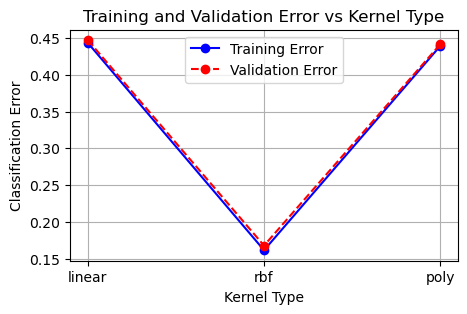

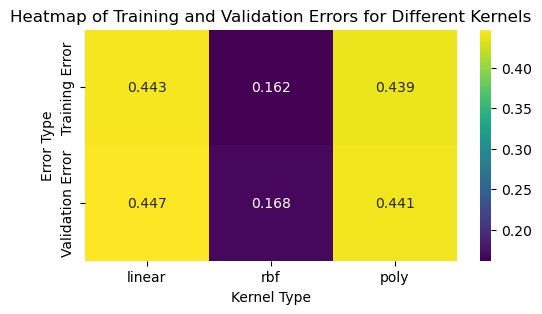


Results for 0.50 Split:

Kernel  Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
linear        0.658896             0.659324       0.659468                   0.665949
   rbf        0.806459             0.807100       0.811718                   0.791060
  poly        0.557742             0.558383       0.563990                   0.556031

Average Results:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.674366             0.674936       0.678392                   0.671013


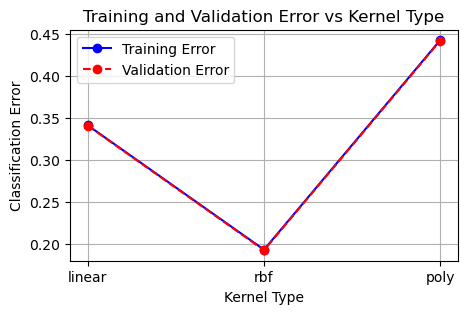

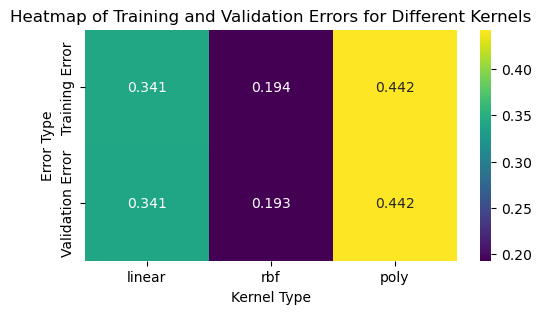


Results for 0.80 Split:

Kernel  Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
linear        0.552139             0.541263       0.558073                   0.549473
   rbf        0.752674             0.749415       0.737102                   0.693628
  poly        0.553476             0.546275       0.561481                   0.553478

Average Results:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
        0.61943             0.612318       0.618885                   0.598859


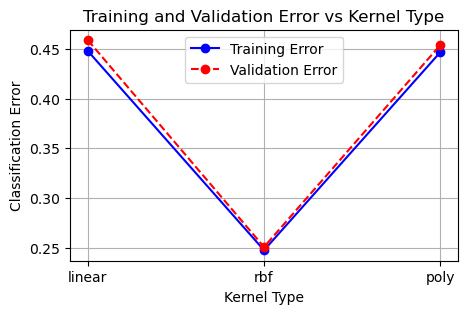

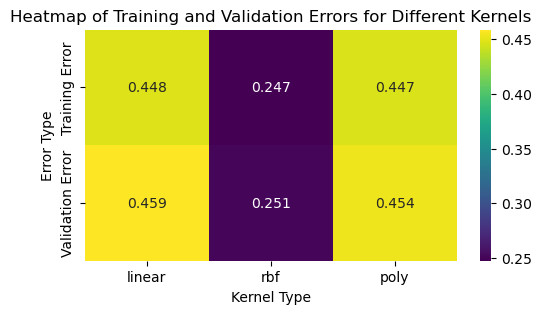

In [6]:
## SVM
print("Results for 0.20 Split:\n")
train_and_evaluate_svm(X_eeg_train_val_80, y_eeg_train_val_80, X_eeg_val_20, y_eeg_val_20, X_eeg_test_20, y_eeg_test_20)
print("\nResults for 0.50 Split:\n")
train_and_evaluate_svm(X_eeg_train_val_50, y_eeg_train_val_50, X_eeg_val_50, y_eeg_val_50, X_eeg_test_50, y_eeg_test_50)
print("\nResults for 0.80 Split:\n")
train_and_evaluate_svm(X_eeg_train_val_20, y_eeg_train_val_20, X_eeg_val_80, y_eeg_val_80, X_eeg_test_80, y_eeg_test_80)

In [7]:
##Logistic regression
def train_and_evaluate_log_reg(X_train, y_train, X_val, y_val, X_test, y_test):

    C = [0.1, 1, 10]
    penalty = ['l2', 'l2', 'l2']
    max_iter = [50, 100, 200]
    results = []
    training_errors = []
    validation_errors = []
    
    for c in range(3):
    
        sc_X = StandardScaler()
        X_train = sc_X.fit_transform(X_train)
        X_test = sc_X.transform(X_test)
        X_val = sc_X.transform(X_val)
    
        log_reg = LogisticRegression(C = C[c], penalty = penalty[c], max_iter = max_iter[c])
    
        scores = cross_val_score(log_reg, X_train, y_train, cv=3, scoring='accuracy')
        
        log_reg.fit(X_train, y_train)
        
        y_pred_test = log_reg.predict(X_test)
        y_pred_train = log_reg.predict(X_train)
        y_pred_val = log_reg.predict(X_val)
        
        accuracy_test = accuracy_score(y_test, y_pred_test)
        accuracy_train = accuracy_score(y_train, y_pred_train)
        accuracy_val = accuracy_score(y_val, y_pred_val)
        cross_val_mean = scores.mean()
    
        train_error = 1 - accuracy_train
        val_error = 1 - accuracy_val
        training_errors.append(train_error)
        validation_errors.append(val_error)
        
        results.append({'Train Accuracy': accuracy_train, 'Validation Accuracy': accuracy_val, 'Test Accuracy': accuracy_test, 'Cross-Validation Accuracy': cross_val_mean})

    results_df = pd.DataFrame(results)
    
    avg_results = results_df[['Train Accuracy', 'Validation Accuracy', 'Test Accuracy', 'Cross-Validation Accuracy']].mean()
    avg_results_df = pd.DataFrame(avg_results).transpose()
    
    print(results_df.to_string(index=False))

    print("\nAverage Results:\n")
    print(avg_results_df.to_string(index=False))

    plt.figure(figsize=(5, 3))
    plt.plot(C, training_errors, label='Training Error', marker='o', linestyle='-', color='blue')
    plt.plot(C, validation_errors, label='Validation Error', marker='o', linestyle='--', color='red')
    plt.xlabel('C Value')
    plt.ylabel('Classification Error')
    plt.title('Training and Validation Error vs C Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    error_matrix = np.array([training_errors, validation_errors]) 

    plt.figure(figsize=(6, 3))
    sns.heatmap(error_matrix, annot=True, fmt=".3f", cmap='viridis', xticklabels=C, yticklabels=['Training Error', 'Validation Error'])
    plt.title('Heatmap of Training and Validation Errors for Different C Values')
    plt.xlabel('C Value')
    plt.ylabel('Error Type')
    plt.show()

Results for 0.20 Split:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.553504             0.548613       0.554932                   0.553504
       0.551750             0.550952       0.554665                   0.548660
       0.551082             0.550952       0.554130                   0.546989

Average Results:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.552112             0.550173       0.554575                   0.549718


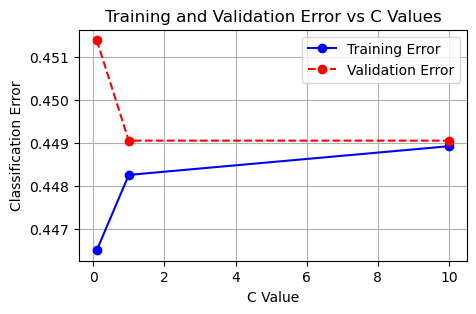

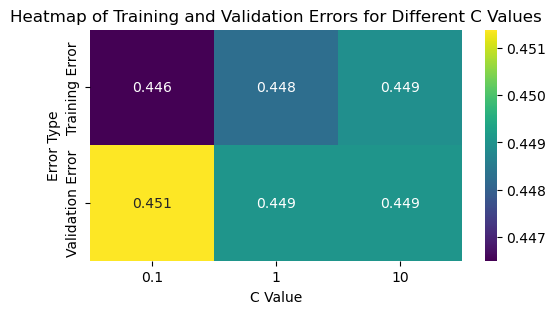


Results for 0.50 Split:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.543627             0.540847       0.549877                   0.546408
       0.810308             0.809025       0.816316                   0.798762
       0.793413             0.788281       0.796643                   0.799188

Average Results:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.715783             0.712717       0.720945                   0.714786


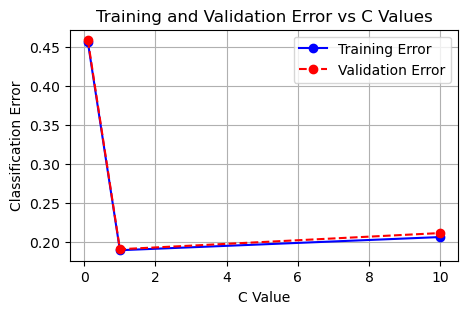

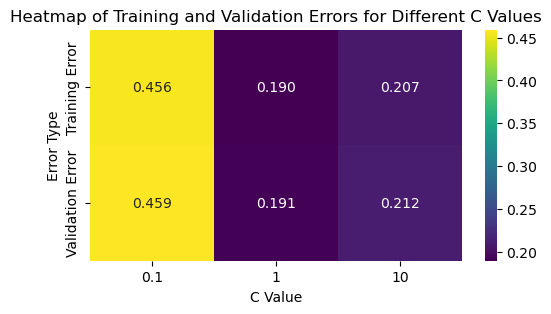


Results for 0.80 Split:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.552139             0.540929       0.558073                   0.549473
       0.544118             0.530237       0.550254                   0.544134
       0.750000             0.727030       0.736300                   0.756535

Average Results:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.615419             0.599399       0.614876                   0.616714


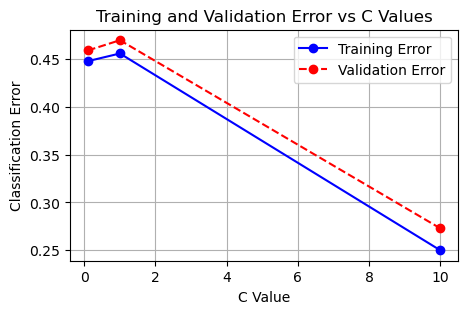

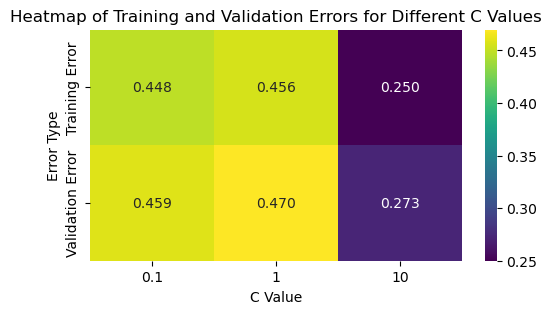

In [8]:
## log_reg
print("Results for 0.20 Split:\n")
train_and_evaluate_log_reg(X_eeg_train_val_80, y_eeg_train_val_80, X_eeg_val_20, y_eeg_val_20, X_eeg_test_20, y_eeg_test_20)
print("\nResults for 0.50 Split:\n")
train_and_evaluate_log_reg(X_eeg_train_val_50, y_eeg_train_val_50, X_eeg_val_50, y_eeg_val_50, X_eeg_test_50, y_eeg_test_50)
print("\nResults for 0.80 Split:\n")
train_and_evaluate_log_reg(X_eeg_train_val_20, y_eeg_train_val_20, X_eeg_val_80, y_eeg_val_80, X_eeg_test_80, y_eeg_test_80)

In [9]:
##Decision Tree
def train_and_evaluate_dt(X_train, y_train, X_val, y_val, X_test, y_test):

    values = [3, 5, 10]
    results = []
    training_errors = []
    validation_errors = []

    for c in range(3):

        dt = DecisionTreeClassifier(max_depth = values[c], min_samples_split = values[c])
    
        scores = cross_val_score(dt, X_train, y_train, cv=3, scoring='accuracy')
        
        dt.fit(X_train, y_train)
        
        y_pred_test = dt.predict(X_test)
        y_pred_train = dt.predict(X_train)
        y_pred_val = dt.predict(X_val)
        
        accuracy_test = accuracy_score(y_test, y_pred_test)
        accuracy_train = accuracy_score(y_train, y_pred_train)
        accuracy_val = accuracy_score(y_val, y_pred_val)
        cross_val_mean = scores.mean()

        train_error = 1 - accuracy_train
        val_error = 1 - accuracy_val
        training_errors.append(train_error)
        validation_errors.append(val_error)

        results.append({'Train Accuracy': accuracy_train, 'Validation Accuracy': accuracy_val, 'Test Accuracy': accuracy_test, 'Cross-Validation Accuracy': cross_val_mean})

    results_df = pd.DataFrame(results)
    
    avg_results = results_df[['Train Accuracy', 'Validation Accuracy', 'Test Accuracy', 'Cross-Validation Accuracy']].mean()
    avg_results_df = pd.DataFrame(avg_results).transpose()
    
    print(results_df.to_string(index=False))

    print("\nAverage Results:\n")
    print(avg_results_df.to_string(index=False))

    plt.figure(figsize=(5, 3))
    plt.plot(values, training_errors, label='Training Error', marker='o', linestyle='-', color='blue')
    plt.plot(values, validation_errors, label='Validation Error', marker='o', linestyle='--', color='red')
    plt.xlabel('Parameter Values')
    plt.ylabel('Classification Error')
    plt.title('Training and Validation Error vs Parameter Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    error_matrix = np.array([training_errors, validation_errors]) 

    plt.figure(figsize=(6, 3))
    sns.heatmap(error_matrix, annot=True, fmt=".3f", cmap='viridis', xticklabels=values, yticklabels=['Training Error', 'Validation Error'])
    plt.title('Heatmap of Training and Validation Errors for Different Parameter Values')
    plt.xlabel('Parameter Values')
    plt.ylabel('Error Type')
    plt.show()

Results for 0.20 Split:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.883635             0.882392       0.884256                   0.879459
       0.899674             0.897093       0.901096                   0.892741
       0.953053             0.941530       0.940123                   0.934091

Average Results:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.912121             0.907005       0.908491                   0.902097


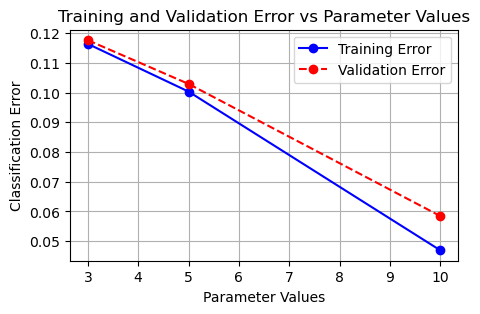

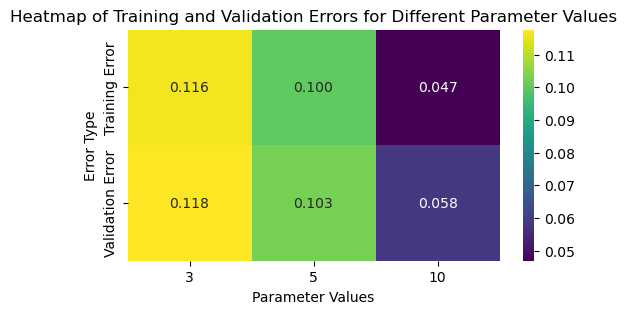


Results for 0.50 Split:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.880667             0.870616       0.877793                   0.874465
       0.899059             0.879812       0.886560                   0.883874
       0.946536             0.909538       0.912755                   0.897564

Average Results:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.908754             0.886655        0.89237                   0.885301


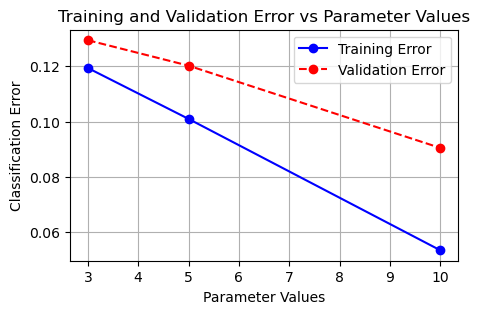

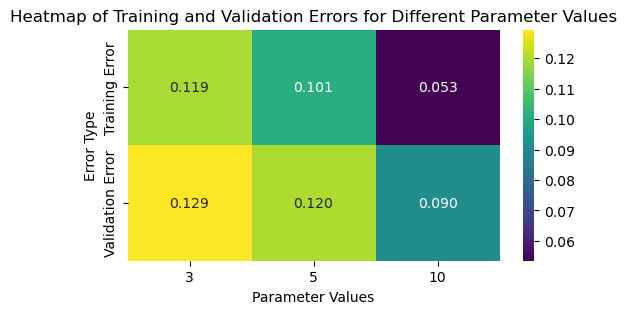


Results for 0.80 Split:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.902406             0.853659       0.873296                   0.886378
       0.926471             0.854661       0.866480                   0.879695
       0.959893             0.859338       0.864341                   0.883711

Average Results:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
        0.92959             0.855886       0.868039                   0.883261


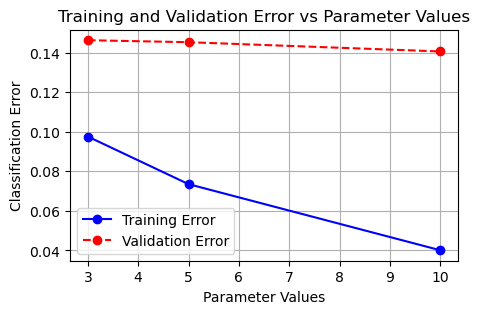

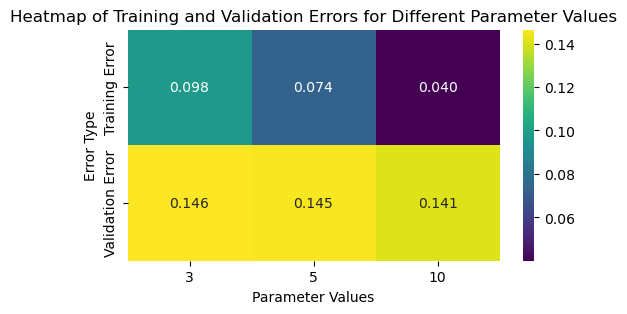

In [10]:
## dt
print("Results for 0.20 Split:\n")
train_and_evaluate_dt(X_eeg_train_val_80, y_eeg_train_val_80, X_eeg_val_20, y_eeg_val_20, X_eeg_test_20, y_eeg_test_20)
print("\nResults for 0.50 Split:\n")
train_and_evaluate_dt(X_eeg_train_val_50, y_eeg_train_val_50, X_eeg_val_50, y_eeg_val_50, X_eeg_test_50, y_eeg_test_50)
print("\nResults for 0.80 Split:\n")
train_and_evaluate_dt(X_eeg_train_val_20, y_eeg_train_val_20, X_eeg_val_80, y_eeg_val_80, X_eeg_test_80, y_eeg_test_80)

In [11]:
##Random forest
def train_and_evaluate_rf(X_train, y_train, X_val, y_val, X_test, y_test):

    n_estimators = [10, 50, 100]
    max_depth = [None, 10, 20]
    results = []
    training_errors = []
    validation_errors = []

    for c in range(3):

        rf = RandomForestClassifier(n_estimators = n_estimators[c], max_depth = max_depth[c])
    
        scores = cross_val_score(rf, X_train, y_train, cv=3, scoring='accuracy')
        
        rf.fit(X_train, y_train)
        
        y_pred_test = rf.predict(X_test)
        y_pred_train = rf.predict(X_train)
        y_pred_val = rf.predict(X_val)
        
        accuracy_test = accuracy_score(y_test, y_pred_test)
        accuracy_train = accuracy_score(y_train, y_pred_train)
        accuracy_val = accuracy_score(y_val, y_pred_val)
        cross_val_mean = scores.mean()

        train_error = 1 - accuracy_train
        val_error = 1 - accuracy_val
        training_errors.append(train_error)
        validation_errors.append(val_error)
    
        results.append({'Train Accuracy': accuracy_train, 'Validation Accuracy': accuracy_val, 'Test Accuracy': accuracy_test, 'Cross-Validation Accuracy': cross_val_mean})

    results_df = pd.DataFrame(results)
    
    avg_results = results_df[['Train Accuracy', 'Validation Accuracy', 'Test Accuracy', 'Cross-Validation Accuracy']].mean()
    avg_results_df = pd.DataFrame(avg_results).transpose()
    
    print(results_df.to_string(index=False))

    print("\nAverage Results:\n")
    print(avg_results_df.to_string(index=False))

    plt.figure(figsize=(5, 3))
    plt.plot(n_estimators, training_errors, label='Training Error', marker='o', linestyle='-', color='blue')
    plt.plot(n_estimators, validation_errors, label='Validation Error', marker='o', linestyle='--', color='red')
    plt.xlabel('n_estimators')
    plt.ylabel('Classification Error')
    plt.title('Training and Validation Error vs n_estimators')
    plt.legend()
    plt.grid(True)
    plt.show()

    error_matrix = np.array([training_errors, validation_errors]) 

    plt.figure(figsize=(6, 3))
    sns.heatmap(error_matrix, annot=True, fmt=".3f", cmap='viridis', xticklabels=n_estimators, yticklabels=['Training Error', 'Validation Error'])
    plt.title('Heatmap of Training and Validation Errors for Different n_estimators')
    plt.xlabel('n_estimators')
    plt.ylabel('Error Type')
    plt.show()

Results for 0.20 Split:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.999666             0.990311       0.992248                   0.977863
       0.963077             0.957902       0.948677                   0.947289
       1.000000             0.992650       0.993852                   0.984462

Average Results:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.987581             0.980287       0.978259                   0.969872


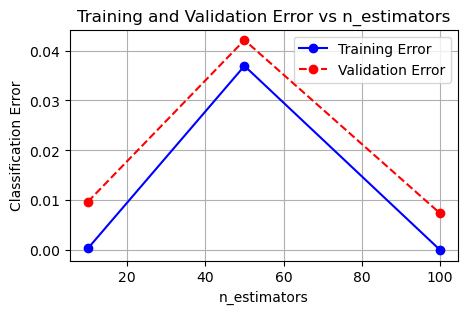

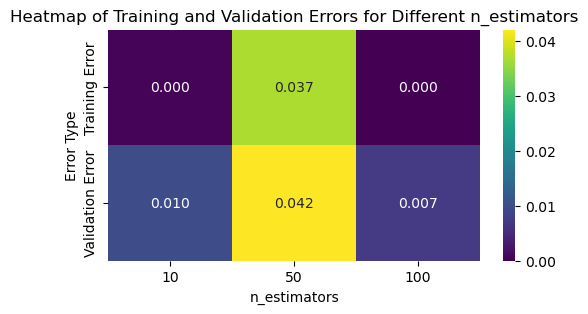


Results for 0.50 Split:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.994654             0.946963       0.952422                   0.930925
       0.969204             0.933276       0.939592                   0.925149
       1.000000             0.957228       0.966321                   0.943969

Average Results:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.987953             0.945823       0.952778                   0.933348


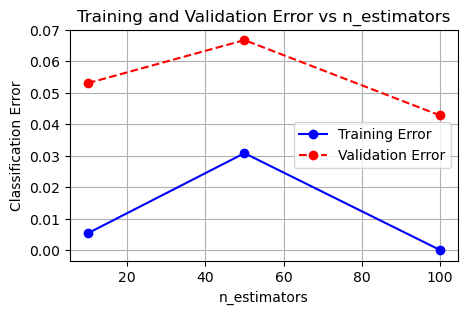

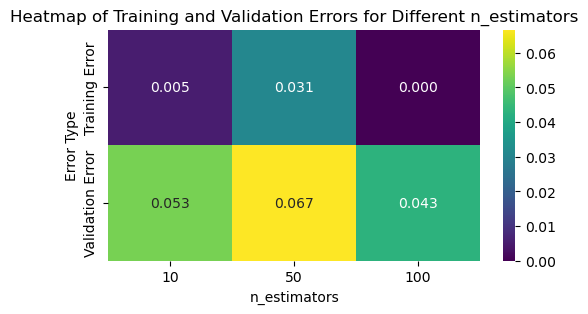


Results for 0.80 Split:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.987968             0.876378       0.890404                   0.903748
       0.989305             0.885733       0.894814                   0.901087
       1.000000             0.883729       0.894213                   0.901082

Average Results:

 Train Accuracy  Validation Accuracy  Test Accuracy  Cross-Validation Accuracy
       0.992424             0.881947       0.893144                   0.901972


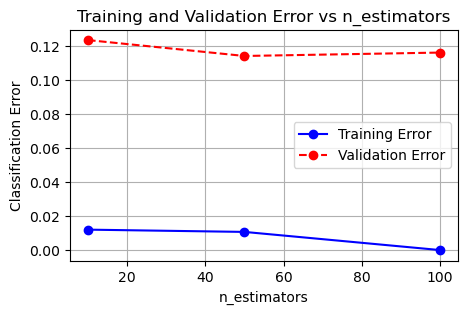

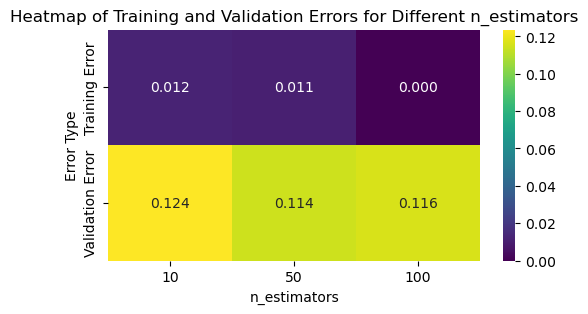

In [12]:
## rf
print("Results for 0.20 Split:\n")
train_and_evaluate_rf(X_eeg_train_val_80, y_eeg_train_val_80, X_eeg_val_20, y_eeg_val_20, X_eeg_test_20, y_eeg_test_20)
print("\nResults for 0.50 Split:\n")
train_and_evaluate_rf(X_eeg_train_val_50, y_eeg_train_val_50, X_eeg_val_50, y_eeg_val_50, X_eeg_test_50, y_eeg_test_50)
print("\nResults for 0.80 Split:\n")
train_and_evaluate_rf(X_eeg_train_val_20, y_eeg_train_val_20, X_eeg_val_80, y_eeg_val_80, X_eeg_test_80, y_eeg_test_80)